In [1]:
%matplotlib inline

#from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras import Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

#JIT for the data generation.
from numba import jit

from IPython import display

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Data Gen

In [2]:
@jit
def Kernel(x, x0):
    sigma = 0.8
    protonFraction = 0.4
    norm = protonFraction/(np.sqrt(2.*np.pi)*sigma)
    return(norm*np.exp(-(x - x0)**2./(2.*sigma**2.)))

@jit
def FakeKernel(x, x0, s):
    sigma = s #Just a slight nudge
    protonFraction = 0.4
    norm = protonFraction/(np.sqrt(2.*np.pi)*sigma)
    return(norm*np.exp(-(x - x0)**2./(2.*sigma**2.)))

In [3]:
@jit
def test_data_gen(fakeKernel=False, sigma=0.4):
    A = 197
    yBeam = 5.36
    slope = 0.5
    sigmaEtas = 0.2
    
    # generate input data
    nBaryons = np.random.randint(0, 2*A)
    randX = np.random.uniform(0, 1, size=nBaryons)
    etasBaryon = 1./slope*np.arcsinh((2.*randX - 1)*np.sinh(slope*yBeam))
    etasArr = np.linspace(-6.4, 6.4, 128)
    dNBdetas = np.zeros(len(etasArr))
    norm = 1./(np.sqrt(2.*np.pi)*sigmaEtas)
    for iB in etasBaryon:
        dNBdetas += norm*np.exp(-(etasArr - iB)**2./(2.*sigmaEtas**2.))
    
    # generate test data with convolution with a kernel
    dNpdy = np.zeros(len(etasArr))
    detas = etasArr[1] - etasArr[0]
    for i in range(len(etasArr)):
        dNpdy[i] = sum(Kernel(etasArr, etasArr[i])*dNBdetas)*detas
    
    if fakeKernel:
        #generate test data with convolution with a fake kernel
        dNBdetasFake = np.random.uniform(0.0, dNBdetas.max(), size=len(etasArr))
        dNpdyFake = np.zeros(len(etasArr))
        detas = etasArr[1] - etasArr[0]
        for i in range(len(etasArr)):
            dNpdyFake[i] = sum(FakeKernel(etasArr, etasArr[i], sigma)*dNBdetas)*detas
            
        return(etasArr, dNBdetas, dNpdy, dNBdetas, dNpdyFake)
    else:
        # generate fake data with random noise
        dNBdetasFake = np.random.uniform(0.0, dNBdetas.max(), size=len(etasArr))
        dNpdyFake = np.random.uniform(0.0, dNpdy.max(), size=len(etasArr))

        return(etasArr, dNBdetas, dNpdy, dNBdetasFake, dNpdyFake)

In [4]:
def show_test_data_graph():
    x, y1, y2, y3, y4 = test_data_gen(fakeKernel=True, sigma=0.1)
    plt.plot(x, y1)
    plt.plot(x, y2)
    fig = plt.figure()
    plt.plot(x, y3)
    plt.plot(x, y4)
    fig = plt.figure()

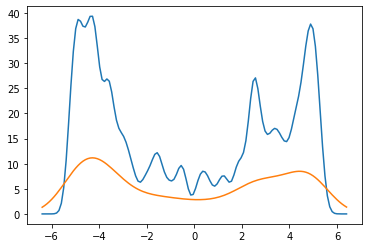

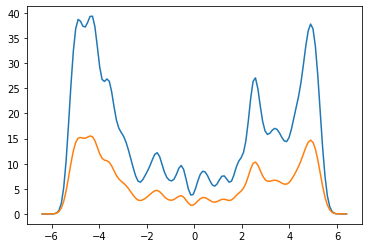

<Figure size 432x288 with 0 Axes>

In [5]:
show_test_data_graph()

In [6]:
#Depth is the number of data generated per size. For example, if your batch size is 
DEPTH = 2

def generate_data(size=500):
    dataArr = []
    labelArr = []  
    for iev in range(int(size/DEPTH)):
        x, y1, y2, y3, y4 = test_data_gen(fakeKernel=False)
        
        # real data
        x = y2
        dataArr.append(x)
        labelArr.append(1)
        
        # fake data: random
        x = y4
        dataArr.append(x)
        labelArr.append(0)
        
    return(np.array(dataArr, dtype=np.float32), np.array(labelArr))

# Generator and Discriminator Models

In [7]:
DFILTER = 32
DKERNEL = "he_normal"
DROPOUT_RATE = 0.4

In [8]:
def define_discriminator(dimShape=(128,1)):
    #Sequential model
    model = Sequential([
        layers.Input(shape=dimShape),
        
        layers.Conv1D(DFILTER, 4, strides = 2, activation="LeakyReLU", padding="same", kernel_initializer=DKERNEL),
        layers.Dropout(DROPOUT_RATE),
        layers.Conv1D(DFILTER, 4, strides = 2, activation="LeakyReLU", padding="same", kernel_initializer=DKERNEL),
        layers.Dropout(DROPOUT_RATE),
        layers.Conv1D(DFILTER, 4, strides = 2, activation="LeakyReLU", padding="same", kernel_initializer=DKERNEL),
        layers.Dropout(DROPOUT_RATE),
        layers.Conv1D(DFILTER, 4, strides = 2, activation="LeakyReLU", padding="same", kernel_initializer=DKERNEL),
        
        layers.GlobalMaxPool1D(),
        
        layers.Dense(1, activation="sigmoid")
    ])
    model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return(model)

In [9]:
BATCH_SIZE = 128
LATENT_DIM = 16
KERNEL_SIZE = 3
KERNEL_INITIALIZER = "ones"

#Feature maps
FILTER = 128

In [10]:
def define_generator():

    model = Sequential([
        layers.Input(shape=(LATENT_DIM,)),
        #We then reshape this into 2D space of size
        layers.Dense(LATENT_DIM * FILTER, input_dim=FILTER, activation="LeakyReLU"),
        layers.Reshape((LATENT_DIM, FILTER)),
        
        #From here, we work to size up to the output shape that we want.
        layers.Conv1DTranspose(FILTER, KERNEL_SIZE, strides = 2, padding="same", kernel_initializer=KERNEL_INITIALIZER),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv1DTranspose(FILTER, KERNEL_SIZE, strides = 2, padding="same", kernel_initializer=KERNEL_INITIALIZER),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv1DTranspose(FILTER, KERNEL_SIZE, strides = 2, padding="same", kernel_initializer=KERNEL_INITIALIZER),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv1D(1,1, activation="sigmoid")
    ])

    model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return(model)

# Pre-train the Disciminator

In [11]:
G = define_generator()
D = define_discriminator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              34816     
                                                                 
 reshape (Reshape)           (None, 16, 128)           0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 32, 128)          49280     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 32, 128)          512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 128)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 64, 128)          4

In [12]:
def train_discriminator_only(data_size=1024, epochs = 200, save_model=False):
    data, label = generate_data(data_size)
    
    #Fit will actually train the model.
    # X: input of shape (141,2)
    # Y: target catagorization, either 1 or 0. Shape (141,2) for consistancy with X
    D.fit(
        x=np.array(data),
        y=np.array(label),
        epochs=epochs,
        shuffle=True,
        validation_split=0.1,
        use_multiprocessing=True,
        workers=25,
        verbose=0
    )
    
    # generate testing data
    test_data_size = data_size
    testData, testLabels = generate_data(test_data_size)
    predictions = D.predict(testData)
    fig = plt.figure()
    #We multiply by 4 here because for each dataset, there are 4 points of data.
    plt.hist(abs(predictions.reshape(test_data_size*2) - testLabels), 50)
    plt.xlim([-0.05, 1.05])
    
    if save_model:
        D.save_weights('./model/checkpoint')

# Defining the Loss Functions

In [13]:
d_cross_entropy = BinaryCrossentropy(from_logits=True)
g_cross_entropy = BinaryCrossentropy(from_logits=True)

generator_optimizer = Adam(learning_rate = 0.0001)
discriminator_optimizer = Adam(learning_rate = 0.00001)

In [14]:
#Source: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
@tf.function
def train_step(data):
    fake = G(tf.random.normal(shape=(BATCH_SIZE, LATENT_DIM)), training=False)
    
    combined = tf.concat([data, fake], axis=0)
    
    labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))])
    
    labels += 0.05 * tf.random.uniform(labels.shape)
    
    #https://www.tensorflow.org/guide/autodiff
    with tf.GradientTape() as disc_tape:
        predictions = D(combined)
        d_loss = d_cross_entroy(labels, predictions)
    
    gradients_of_discriminator = disc_tape.gradient(d_loss, D.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))
    
    wrong_labels = tf.zeros((BATCH_SIZE, 1))
    
    with tf.GradientTape() as gen_tape:
        predictions = D(G(tf.random.normal((BATCH_SIZE, LATENT_DIM))))
        g_loss = g_cross_entroy(wrong_labels, predictions)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
    
    return g_loss, d_loss

In [15]:
def train(epochs):
    total_gen_loss = []
    total_disc_loss = []
    
    for epoch in range(epochs):
        display.clear_output(wait=True)
        print("Epoch: " + str(epoch+1))
        data, _ = generate_data(size=BATCH_SIZE)
        gen_loss, disc_loss = train_step(data)
        total_gen_loss.append(gen_loss)
        total_disc_loss.append(disc_loss)
    return np.array(total_gen_loss), np.array(total_disc_loss)

In [16]:
# data, label = generate_data(1024)

# Nepochs = 100

# D.fit(
#     x=np.array(data),
#     y=np.array(label),
#     epochs=Nepochs,
#     shuffle=True,
#     validation_split=0.1,
#     use_multiprocessing=True,
#     workers=25,
#     verbose=0
# )

(-0.05, 1.05)

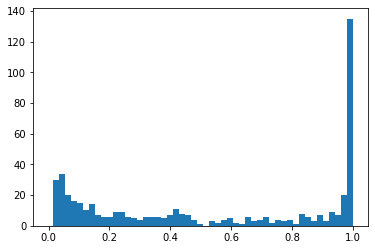

In [18]:
testData, testLabels = generate_data(500)

predictions = D.predict(testData)

fig = plt.figure()
plt.hist(abs(predictions.reshape(500) - testLabels), 50)
plt.xlim([-0.05, 1.05])

In [19]:
total_gen_loss, total_disc_loss = train(2000)

Epoch: 1


ValueError: in user code:

    File "/var/folders/xc/y6t34tms1pv1hptzwlzrrscc0000gn/T/ipykernel_47829/1713790272.py", line 6, in train_step  *
        combined = tf.concat([data, fake], axis=0)

    ValueError: Shape must be rank 2 but is rank 3 for '{{node concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](data, sequential/conv1d/Sigmoid, concat/axis)' with input shapes: [128,128], [128,128,1], [].


In [ ]:
print(total_disc_loss[len(total_disc_loss)-1])
print(total_gen_loss[len(total_gen_loss)-1])
plt.plot(np.arange(0, len(total_gen_loss), 1, int ), total_gen_loss)
plt.plot(np.arange(0, len(total_disc_loss), 1, int ), total_disc_loss)
fig=plt.Figure()

In [ ]:
for i in range(2):
    noise = tf.random.normal([1, LATENT_DIM])
    generated_data = G(noise, training=False)
    print(D.predict(generated_data))
    generated_data = generated_data.numpy().flatten()
    plt.plot(np.arange(0, len(generated_data), 1, int ), generated_data)
    fig=plt.Figure()

(-0.05, 1.05)

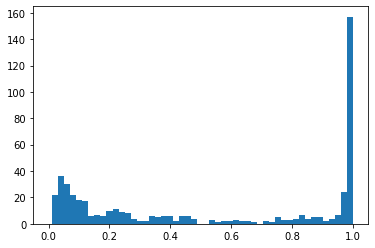

In [20]:
testData, testLabels = generate_data(500)

predictions = D.predict(testData)

fig = plt.figure()
plt.hist(abs(predictions.reshape(500) - testLabels), 50)
plt.xlim([-0.05, 1.05])